# 🧠 DSSM Homework: Improve the Model

Welcome! This assignment builds upon the DSSM model you studied during the seminar.

Your task is to **improve the DSSM model** by modifying the architecture, loss function, evaluation, or training pipeline. This is an open-ended assignment meant to encourage exploration.

In this seminar, you've explored a basic implementation of the Deep Structured Semantic Model (DSSM).

Your task is to **improve this model** in one or more of the following directions:

### ✅ Model Improvements
- [ ] Replace MLP towers with Transformer or RNN encoders or etc. (5 баллов)
- [x] Use different triplet loss. (3 балла)
- [x] Add dropout, batch normalization, or layer norm. (3 балла)
- [x] Integrate embeddings instead of one-hot vectors. (5 баллов)
- [ ] Visualize similarity distribution for positive vs. negative pairs. (5 баллов)

### ✅ Evaluation & Analysis
- [x] Visualize embeddings using t-SNE or UMAP. (3 баллов)
- [x] Develop and improve beyond accuracy metrics. (5 баллов)

### 📄 Deliverables
- [x] Explain what you changed and why in the final markdown cell. (3 балла)
- [x] Keep code modular, clean, and well-documented. (3 балла)

### 📝 Production
- create service based on DSSM vectors with ANN. (8 баллов)

### 📝 Leaderboard
- Improve score from UserKNN via DSSM (8 баллов)


Максимум баллов, которые можно получить - 25.

In [5]:
# ----------------------
# 2. IMPORTS AND SETUP
# ----------------------
import os
import requests
import zipfile
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
import warnings
import umap
warnings.filterwarnings("ignore")

In [6]:
# ----------------------
# 3. DOWNLOAD AND LOAD DATA
# ----------------------
def download_and_extract():
    url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'
    filename = 'kion_train.zip'

    response = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        total = int(response.headers.get('content-length', 0))
        progress = tqdm(response.iter_content(1024 * 1024),
                        f"Downloading {filename}",
                        total=total // (1024 * 1024), unit='MB')
        for chunk in progress:
            f.write(chunk)

    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall("data")
    os.remove(filename)

if not os.path.exists("data/data_original"):
    download_and_extract()



In [7]:
# ----------------------
# 4. DATA PREPROCESSING
# ----------------------
interactions_df = pd.read_csv('data/data_original/interactions.csv', parse_dates=["last_watch_dt"])
users_df = pd.read_csv('data/data_original/users.csv')
items_df = pd.read_csv('data/data_original/items.csv')

# Label Encoding
Вместо использования one-hot векторов закодируем каждую фичу

In [8]:
# Input:
# - user_df - исходный датафрейм с юзерами

# Oupput:
# - user_df - отфильтрованный датафрейм

# Преобразования:
# - Фильтруем не нужные фичи в датафрейме

from sklearn.preprocessing import LabelEncoder

# Заполняем строки "unknown"
for col in ['income', 'sex', 'age']:
    users_df[col] = users_df[col].fillna('unknown')

USERS_FEATURES = ["age", "income", "sex", "kids_flg"]
users_df = users_df[USERS_FEATURES + ["user_id"]]

# Encoding
user_encoders = {}
for feat in USERS_FEATURES:
    le = LabelEncoder()
    users_df[feat] = le.fit_transform(users_df[feat])
    user_encoders[feat] = le

users_df.head()


,age,income,sex,kids_flg,user_id
0,1,4,2,1,973171
1,0,2,2,0,962099
2,3,3,1,0,1047345
3,3,2,1,0,721985
4,2,4,1,0,704055


In [9]:
# Input:
# - items_df - исходный датафрейм с айтемами

# Oupput:
# - items_df - отфильтрованный датафрейм

# Преобразования:
# - Фильтруем не нужные фичи в датафрейме
# - Избавляемся от NaN значений

ITEMS_FEATURES = ['content_type', 'release_year', 'for_kids', 'age_rating', 'studios', 'countries', 'directors']

# Заполняем строки "unknown"
for col in ['content_type', 'studios', 'countries', 'directors']:
    items_df[col] = items_df[col].fillna('unknown')

# Заполняем числовые фичи специальным значением (-1)
for col in ['release_year', 'for_kids', 'age_rating']:
    items_df[col] = items_df[col].fillna(-1)

items_df = items_df[ITEMS_FEATURES + ['item_id']]

item_encoders = {}
for feat in ITEMS_FEATURES:
    le = LabelEncoder()
    items_df[feat] = le.fit_transform(items_df[feat])
    item_encoders[feat] = le

items_df.head()

,content_type,release_year,for_kids,age_rating,studios,countries,directors,item_id
0,0,86,0,4,33,258,5671,10711
1,0,98,0,4,33,421,6546,2508
2,0,95,0,4,33,298,95,10716
3,0,99,0,4,33,57,7735,7868
4,0,62,0,3,34,419,1544,16268


Для каждой фичи пропишем размерность эмбедингов

In [10]:
items_categorical_size = {feat: items_df[feat].nunique() for feat in ITEMS_FEATURES}
items_features_info = [
    (items_categorical_size['content_type'], 8),
    (items_categorical_size['release_year'], 8),
    (items_categorical_size['for_kids'], 2),
    (items_categorical_size['age_rating'], 8),
    (items_categorical_size['studios'], 16),
    (items_categorical_size['countries'], 8),
    (items_categorical_size['directors'], 16),
]

In [11]:
users_categorical_size = {feat: users_df[feat].nunique() for feat in USERS_FEATURES}
users_features_info = [
    (users_categorical_size['age'], 16),
    (users_categorical_size['income'], 16),
    (users_categorical_size['sex'], 2),
    (users_categorical_size['kids_flg'], 2),
]

# Пре-процессинг
В этой секции происходят базовые преобразования, как было показано на лекции. Исключением лишь является то, что фичи пользователей и айтемов не преобразовываются как one-hot вектора, потому что я буду использовать
обучаемые эмбеддинги

In [12]:
# Input:
# - interactions_df — сырые взаимодействия пользователей с фильмами

# Output:
# - Очищенный interactions_df, содержащий:
#   - Только пользователей, просмотревших более 10 фильмов.
#   - Только фильмы, просмотренные более чем 10 пользователями.
#   - Только взаимодействия, где просмотр фильма превышает 10%.

# Преобразования:
# - Удалены взаимодействия с watched_pct ≤ 10%.
# - Оставлены только активные пользователи (с более чем 10 взаимодействиями).
# - Оставлены только популярные фильмы (с более чем 10 пользователями).
# - Итоговый датасет уменьшен в объеме, но очищен для повышения качества обучения модели.


interactions_df = interactions_df[interactions_df.watched_pct > 10]
valid_users = []
c = Counter(interactions_df.user_id)
for user_id, entries in c.most_common():
    if entries > 10:
        valid_users.append(user_id)
valid_items = []
c = Counter(interactions_df.item_id)
for item_id, entries in c.most_common():
    if entries > 10:
        valid_items.append(item_id)

interactions_df = interactions_df[interactions_df.user_id.isin(valid_users)]
interactions_df = interactions_df[interactions_df.item_id.isin(valid_items)]

In [13]:
# Input:
# - interactions_df — очищенные взаимодействия пользователей и фильмов.
# - users_df — таблица с пользователями и их признаками (НЕ one-hot).
# - items_df — таблица с фильмами и их признаками (НЕ one-hot).

# Output:
# - interactions_df, items_df и users_df — синхронизированные таблицы, содержащие только общих пользователей и фильмы.

# Преобразования:
# - Найдены пересечения пользователей и фильмов, присутствующих одновременно в interactions_df и users_df/items_df.
# - Удалены пользователи и фильмы, отсутствующие в обоих соответствующих датасетах.
# - Гарантирована консистентность между взаимодействиями и признаковыми таблицами (users_df и items_df).


common_users = set(interactions_df.user_id.unique()).intersection(set(users_df.user_id.unique()))
common_items = set(interactions_df.item_id.unique()).intersection(set(items_df.item_id.unique()))

print(len(common_users))
print(len(common_items))

interactions_df = interactions_df[interactions_df.item_id.isin(common_items)]
interactions_df = interactions_df[interactions_df.user_id.isin(common_users)]

items_df = items_df[items_df.item_id.isin(common_items)]
users_df = users_df[users_df.user_id.isin(common_users)]

65974
6901


In [14]:
common_users = set(interactions_df.user_id.unique()).intersection(set(users_df.user_id.unique()))
common_items = set(interactions_df.item_id.unique()).intersection(set(items_df.item_id.unique()))

print(len(common_users))
print(len(common_items))

interactions_df = interactions_df[interactions_df.item_id.isin(common_items)]
interactions_df = interactions_df[interactions_df.user_id.isin(common_users)]

items_df = items_df[items_df.item_id.isin(common_items)]
users_df = users_df[users_df.user_id.isin(common_users)]

65974
6897


# Пост-процессинг : train и test

### Временной сплит для построения interaction матриц:
- Делим interactions_df по дате на train/test по последним N дней.
- Кодируем user_id и item_id в train через категориальные uid и iid.
- Применяем тот же маппинг к test.
- Строим interaction матрицы отдельно для train и test.
- Таким образом, обучаем модель на истории, а тестируем на предсказании будущих интересов пользователя.


In [15]:
# Разбиваем датасет на трейн и тестовую часть
N_DAYS = 7
max_date = interactions_df['last_watch_dt'].max()

train_df = interactions_df[interactions_df['last_watch_dt'] <= max_date - pd.Timedelta(days=N_DAYS)]
test_df = interactions_df[interactions_df['last_watch_dt'] > max_date - pd.Timedelta(days=N_DAYS)]


# Только юзеры, которые были в train
test_df = test_df[test_df['user_id'].isin(train_df['user_id'])]
# Только айтемы, которые были в train
test_df = test_df[test_df['item_id'].isin(train_df['item_id'])]

In [16]:

# категориально закодируем user_id и item_id по train
train_df['uid'] = train_df['user_id'].astype('category').cat.codes
train_df['iid'] = train_df['item_id'].astype('category').cat.codes

# Сделаем маппинг user_id и item_id в uid и iid

uid_to_user_id = dict(zip(train_df['uid'], train_df['user_id']))
iid_to_item_id = dict(zip(train_df['iid'], train_df['item_id']))

user_id_to_uid = dict(zip(train_df['user_id'], train_df['uid']))
item_id_to_iid = dict(zip(train_df['item_id'], train_df['iid']))

# Создадим колонки uid и iid в test_df и применим маппинг

test_df['uid'] = test_df['user_id'].map(user_id_to_uid)
test_df['iid'] = test_df['item_id'].map(item_id_to_iid)

print(f"Test: {test_df.shape}")
print(f"Train: {train_df.shape}")

Test: (83707, 7)
Train: (1375329, 7)


In [17]:
# Оставим только те айтемы которые есть в train

items_df = items_df[items_df['item_id'].isin(train_df['item_id'])]
items_df = items_df.set_index('item_id').loc[train_df['item_id'].unique()].reset_index()

# Убедимся, что количество уникальных айтомов в items_df совпадает с количеством уникальных айтемов в train_df
assert items_df.item_id.nunique() == train_df.item_id.nunique()

In [18]:
# Оставим только тех юзеров которые есть в train

users_df = users_df[users_df['user_id'].isin(train_df['user_id'])]
users_df = users_df.set_index('user_id').loc[train_df['user_id'].unique()].reset_index()

# Убедимся, что количество уникальных юзеров в users_df совпадает с количеством уникальных юзеров в train_df
assert users_df.user_id.nunique() == train_df.user_id.nunique()

In [19]:
# Проверим, что маппинг был корректный
assert test_df[test_df['uid'] == 4375].user_id.values[0] == train_df[train_df['uid'] == 4375].user_id.values[0]

Сделаем матрицу интеракция для train и test. Размерность одинаковая

In [20]:
import numpy as np

n_users = train_df['uid'].nunique()
n_items = train_df['iid'].nunique()

# ==========================

train_vec = np.zeros((n_users, n_items))
for uid, iid in zip(train_df['uid'], train_df['iid']):
    train_vec[uid, iid] += 1

# нормализация
train_vec = train_vec / train_vec.sum(axis=1, keepdims=True)

# ==========================

# для test
test_vec = np.zeros((n_users, n_items))
for uid, iid in zip(test_df['uid'], test_df['iid']):
    test_vec[uid, iid] += 1

test_vec = test_vec / test_vec.sum(axis=1, keepdims=True)

In [21]:
print(f"Train interaction matrix shape : {train_vec.shape}")
print(f"Test interaction matrix shape : {test_vec.shape}")

Train interaction matrix shape : (65792, 6862)
Test interaction matrix shape : (65792, 6862)


In [22]:
print("Train: Размер уникальных юзеров", train_df.uid.nunique())
print("Test: Размер уникальных юзеров", test_df.uid.nunique())


Train: Размер уникальных юзеров 65792
Test: Размер уникальных юзеров 25676


In [23]:
N_FACTORS = 128

ITEM_MODEL_SHAPE = (items_df.drop(["item_id"], axis=1).shape[1], )
USER_META_MODEL_SHAPE = (users_df.drop(["user_id"], axis=1).shape[1], )

USER_INTERACTION_MODEL_SHAPE = (train_vec.shape[1], )

print(f"N_FACTORS: {N_FACTORS}")
print(f"ITEM_MODEL_SHAPE: {ITEM_MODEL_SHAPE}")
print(f"USER_META_MODEL_SHAPE: {USER_META_MODEL_SHAPE}")
print(f"USER_INTERACTION_MODEL_SHAPE: {USER_INTERACTION_MODEL_SHAPE}")

N_FACTORS: 128
ITEM_MODEL_SHAPE: (7,)
USER_META_MODEL_SHAPE: (4,)
USER_INTERACTION_MODEL_SHAPE: (6862,)


# Модель

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ItemModel(nn.Module):
    def __init__(self, items_features_info, hidden_dim=128, output_dim=128, dropout_rate=0.2):
        """
        Args:
            items_features_info: список кортежей (n_categories, embedding_dim) для каждого признака.
            hidden_dim: размер скрытого слоя.
            output_dim: размер итогового эмбеддинга айтема.
        """
        super(ItemModel, self).__init__()

        # Embedding слои для всех категориальных признаков
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, emb_dim) for num_categories, emb_dim in items_features_info
        ])

        self.emb_total_dim = sum(emb_dim for _, emb_dim in items_features_info)

        # MLP после эмбеддингов
        self.mlp = nn.Sequential(
            nn.Linear(self.emb_total_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, item_features):
        """
        item_features: [batch_size, num_features] (индексы категориальных признаков)
        """
        emb_list = []
        for i, emb_layer in enumerate(self.embeddings):
            emb_list.append(emb_layer(item_features[:, i]))

        x = torch.cat(emb_list, dim=-1)
        x = self.mlp(x)
        return x


In [25]:
class UserModel(nn.Module):
    def __init__(self,
                 categorical_feat_info,
                 interaction_input_dim,
                 hidden_dim=128,
                 output_dim=128,
                 dropout_rate=0.2):
        super(UserModel, self).__init__()

        # Embedding layers для всех категориальных признаков
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, emb_dim) for num_categories, emb_dim in categorical_feat_info
        ])

        self.emb_total_dim = sum(emb_dim for _, emb_dim in categorical_feat_info)

        # MLP для признаков пользователя (meta features)
        self.meta_mlp = nn.Sequential(
            nn.Linear(self.emb_total_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # MLP для взаимодействий пользователя
        self.interaction_mlp = nn.Sequential(
            nn.Linear(interaction_input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Финальный слой после склейки
        self.fc_final = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, meta_features, interaction_features):
        """
        meta_features: [batch_size, num_categorical_features] (индексы признаков)
        interaction_features: [batch_size, interaction_input_dim] (float32 признаки)
        """

        # Обработка мета-фичей через эмбеддинги
        emb_list = []
        for i, emb_layer in enumerate(self.embeddings):
            emb_list.append(emb_layer(meta_features[:, i]))

        meta_embedded = torch.cat(emb_list, dim=-1)

        # Обработка через MLP
        meta_vec = self.meta_mlp(meta_embedded)

        # Обработка взаимодействий
        interaction_vec = self.interaction_mlp(interaction_features)

        # Склейка мета + взаимодействий
        combined = torch.cat([meta_vec, interaction_vec], dim=1)

        # Финальный слой
        user_embedding = self.fc_final(combined)

        return user_embedding


# Loss

In [26]:
import torch.nn.functional as F

def cosine_triplet_loss(anchor, positive, negative, alpha=0.4):
    # Нормализуем вектора
    anchor = F.normalize(anchor, p=2, dim=1)
    positive = F.normalize(positive, p=2, dim=1)
    negative = F.normalize(negative, p=2, dim=1)

    # Косинусное расстояние: 1 - cos_sim
    pos_sim = torch.sum(anchor * positive, dim=1)
    neg_sim = torch.sum(anchor * negative, dim=1)

    basic_loss = neg_sim - pos_sim + alpha
    loss = torch.clamp(basic_loss, min=0.0)
    return loss.mean()

# Dataset

In [27]:
# Define the dataset
class RecSysDataset(Dataset):
    def __init__(self, items, users, interactions, uids: list[int]):
        self.items = items
        self.users = users
        self.interactions = interactions
        self.uids = uids

    def __len__(self):
        return len(self.uids)

    def __getitem__(self, idx):
        uid = self.uids[idx]
        pos_i = np.random.choice(range(self.interactions.shape[1]), p=self.interactions[uid])
        neg_i = np.random.choice(range(self.interactions.shape[1]))
        uid_meta = self.users.iloc[uid].values
        uid_interaction = self.interactions[uid]
        pos = self.items.iloc[pos_i].values
        neg = self.items.iloc[neg_i].values

        return torch.tensor(uid_meta, dtype=torch.int), torch.tensor(uid_interaction, dtype=torch.float32), torch.tensor(pos, dtype=torch.int), torch.tensor(neg, dtype=torch.int), uid

# Инициализация перед тренировкой

In [28]:
# Initialize the models, optimizer, and dataset
# i2v = ItemModel(items_features_info)
# u2v = UserModel(users_features_info, USER_INTERACTION_MODEL_SHAPE[0])
# optimizer = optim.Adam(list(i2v.parameters()) + list(u2v.parameters()), lr=0.001)
# dataset = RecSysDataset(items=items_df.drop(["item_id"], axis=1), users=users_df.drop(["user_id"], axis=1), interactions=interactions_vec)
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

i2v = ItemModel(items_features_info)
u2v = UserModel(users_features_info, USER_INTERACTION_MODEL_SHAPE[0])
optimizer = optim.Adam(list(i2v.parameters()) + list(u2v.parameters()), lr=0.001)

dataset = RecSysDataset(items=items_df.drop(["item_id"], axis=1), users=users_df.drop(["user_id"], axis=1), interactions=train_vec, uids=train_df.uid.unique())
test_dataset = RecSysDataset(items=items_df.drop("item_id", axis=1), users=users_df.drop("user_id", axis=1), interactions=test_vec, uids=sorted(test_df.uid.unique()))

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Accuracy function

In [29]:
import numpy as np
import pandas as pd

def map_at_k(reco_df: pd.DataFrame, ground_truth_df: pd.DataFrame, k: int = 10) -> float:
    """
    Calculate Mean Average Precision at K.
    
    Parameters:
        reco_df: pd.DataFrame with columns [user_id, item_id, rank] — predicted top-K items.
        ground_truth_df: pd.DataFrame with columns [user_id, item_id] — actual relevant items.
        k: cutoff for recommendations.
    
    Returns:
        float: MAP@K score
    """

    # Приведём ground truth в структуру {user_id: set(item_ids)}
    gt_dict = ground_truth_df.groupby("user_id")["item_id"].apply(set).to_dict()

    # Приведём рекомендации в структуру {user_id: [item_ids]}
    reco_df = reco_df[reco_df["rank"] <= k]
    reco_dict = reco_df.sort_values(["user_id", "rank"]).groupby("user_id")["item_id"].apply(list).to_dict()

    average_precisions = []

    for user_id, pred_items in reco_dict.items():
        if user_id not in gt_dict:
            continue  # юзера нет в ground truth

        true_items = gt_dict[user_id]
        if not true_items:
            continue

        num_hits = 0
        score = 0.0

        for i, item in enumerate(pred_items):
            if item in true_items:
                num_hits += 1
                precision_at_i = num_hits / (i + 1)
                score += precision_at_i

        if num_hits > 0:
            ap = score / min(len(true_items), k)
            average_precisions.append(ap)

    return np.mean(average_precisions) if average_precisions else 0.0


In [30]:
import torch
import torch.nn.functional as F
import pandas as pd

def evaluate_map_k(model_user, model_item, test_dataloader, test_df, uid_to_user_id, iid_to_item_id, k=10):
    model_user.eval()
    model_item.eval()

    # Предварительно считаем эмбеддинги всех айтемов
    item_feats = torch.tensor(items_df.drop("item_id", axis=1).values, dtype=torch.int)
    with torch.no_grad():
        item_emb = model_item(item_feats)
        item_emb = F.normalize(item_emb, dim=1)

    reco = []

    with torch.no_grad():
        for batch in test_dataloader:
            uid_meta, uid_interaction, _, _, batch_uids = batch

            user_emb = model_user(uid_meta, uid_interaction)
            user_emb = F.normalize(user_emb, dim=1)

            sim = torch.matmul(user_emb, item_emb.T)  # [batch_size, n_items]
            _, topk_indices = torch.topk(sim, k=k, dim=1)

            for i, item_idxs in enumerate(topk_indices):
                real_uid = batch_uids[i].item()  # uid из датасета
                real_user_id = uid_to_user_id[real_uid]

                for rank, iid in enumerate(item_idxs):
                    reco.append({
                        "user_id": real_user_id,
                        "item_id": iid_to_item_id[iid.item()],
                        "rank": rank + 1
                    })

    reco_df = pd.DataFrame(reco)
    ground_truth = test_df[["user_id", "item_id"]].drop_duplicates()

    score = map_at_k(reco_df, ground_truth, k=k)
    return score


# Training

In [31]:
import logging

# Set up logging
logging.basicConfig(filename='training.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

losses = []
metrics = []

# Training loop
for epoch in range(2):
    for idx, batch in enumerate(dataloader):
        uid_meta, uid_interaction, pos, neg, _ = batch
        optimizer.zero_grad()
        anchor = u2v(uid_meta, uid_interaction)
        positive = i2v(pos)
        negative = i2v(neg)
        loss = cosine_triplet_loss(anchor, positive, negative)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        print(f"Epoch {epoch + 1}, Batch {idx}, Loss: {loss.item()}")
        
        if idx % 100 == 0:
            mapk = map_score = evaluate_map_k(
                        model_user=u2v,
                        model_item=i2v,
                        test_dataloader=test_dataloader,
                        test_df=test_df,
                        uid_to_user_id=uid_to_user_id,
                        iid_to_item_id=iid_to_item_id,
                        k=10
                    )
            metrics.append(mapk)
            print(f"MAP@10: {mapk:.4f}")

    print(f"Epoch {epoch + 1}, Epoch Loss: {loss.item()}")

Epoch 1, Batch 0, Loss: 0.409328818321228
MAP@10: 0.0707
Epoch 1, Batch 1, Loss: 0.41052907705307007
Epoch 1, Batch 2, Loss: 0.3956069350242615
Epoch 1, Batch 3, Loss: 0.4031674861907959
Epoch 1, Batch 4, Loss: 0.395466685295105
Epoch 1, Batch 5, Loss: 0.38397687673568726
Epoch 1, Batch 6, Loss: 0.3922419250011444
Epoch 1, Batch 7, Loss: 0.3940025568008423
Epoch 1, Batch 8, Loss: 0.40137356519699097
Epoch 1, Batch 9, Loss: 0.36376357078552246
Epoch 1, Batch 10, Loss: 0.36401090025901794
Epoch 1, Batch 11, Loss: 0.4085378050804138
Epoch 1, Batch 12, Loss: 0.33493784070014954
Epoch 1, Batch 13, Loss: 0.3674120306968689
Epoch 1, Batch 14, Loss: 0.35714104771614075
Epoch 1, Batch 15, Loss: 0.3635317385196686
Epoch 1, Batch 16, Loss: 0.37421131134033203
Epoch 1, Batch 17, Loss: 0.35601750016212463
Epoch 1, Batch 18, Loss: 0.3089226484298706
Epoch 1, Batch 19, Loss: 0.3297487199306488
Epoch 1, Batch 20, Loss: 0.3844873309135437
Epoch 1, Batch 21, Loss: 0.331882506608963
Epoch 1, Batch 22, Lo

Построим график Лосса и метрики

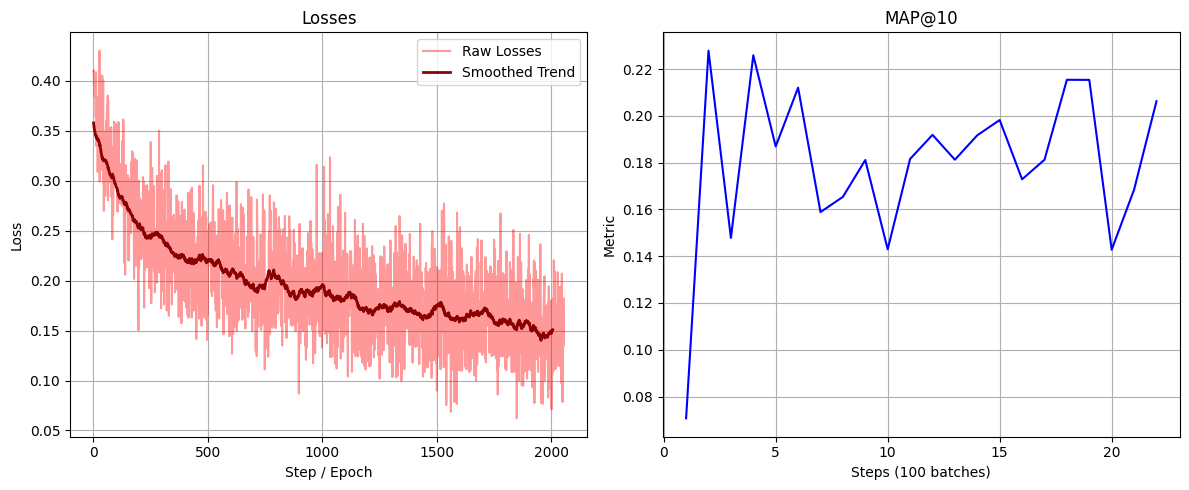

In [32]:
loss_steps = list(range(1, len(losses) + 1))
metric_steps = list(range(1, len(metrics) + 1))

def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

losses_smooth = moving_average(losses, window_size=50)
smooth_steps = loss_steps[:len(losses_smooth)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(loss_steps, losses, color='red', alpha=0.4, label='Raw Losses')
ax1.plot(smooth_steps, losses_smooth, color='darkred', linewidth=2, label='Smoothed Trend')
ax1.set_title('Losses')
ax1.set_xlabel('Step / Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# График Metrics
ax2.plot(metric_steps, metrics, color='blue')
ax2.set_title('MAP@10')
ax2.set_xlabel('Steps (100 batches)')
ax2.set_ylabel('Metric')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Visualize embeddings

In [33]:
item_features = items_df[ITEMS_FEATURES].values
item_features = torch.tensor(item_features, dtype=torch.long)

with torch.no_grad():
    item_embeddings = i2v(item_features)
    item_embeddings = item_embeddings.cpu().numpy()


In [34]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
item_embeddings_2d = reducer.fit_transform(item_embeddings)


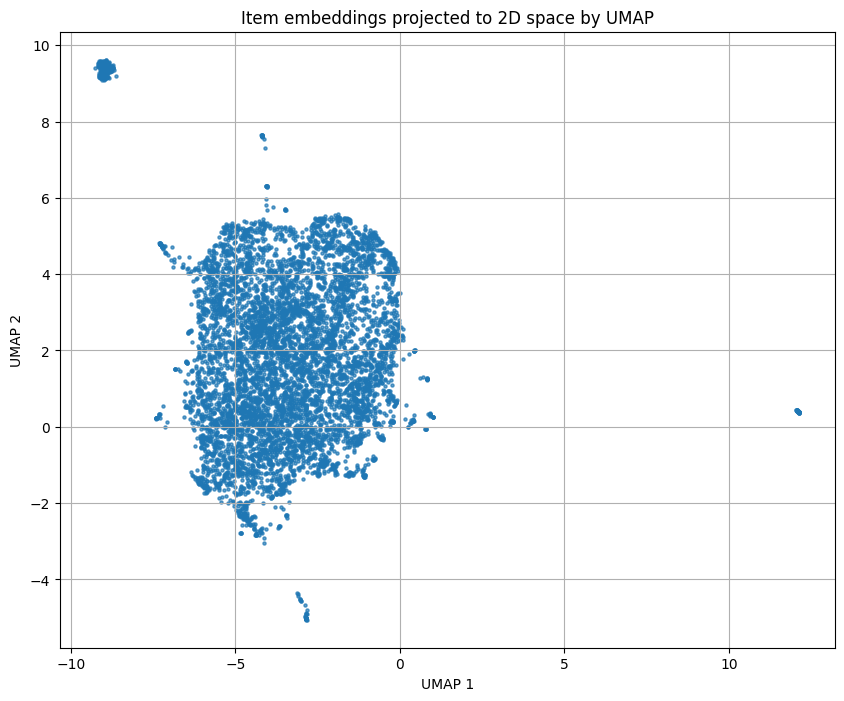

In [35]:
plt.figure(figsize=(10, 8))
plt.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1], s=5, alpha=0.7)
plt.title('Item embeddings projected to 2D space by UMAP')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()

# Inference

In [39]:
# Inference:
# Get user and item features
rand_uid = np.random.choice(list(users_df.index))
user_meta_feats = users_df.drop(["user_id"], axis=1).iloc[rand_uid].values
user_interaction_vec = test_vec[rand_uid]
rand_iid = np.random.choice(list(items_df.index))
item_feats = items_df.drop(["item_id"], axis=1).iloc[rand_iid].values

# Convert to PyTorch tensors
user_meta_feats = torch.tensor(user_meta_feats, dtype=torch.int)
user_interaction_vec = torch.tensor(user_interaction_vec, dtype=torch.float32)
item_feats = torch.tensor(item_feats, dtype=torch.long)

# Set the models to evaluation mode before inference
i2v.eval()
u2v.eval()

# Get user and item embeddings
user_vec = u2v(user_meta_feats.unsqueeze(0), user_interaction_vec.unsqueeze(0))
item_vec = i2v(item_feats.unsqueeze(0))

In [ ]:
# Inference:
# Get user and item features
rand_uid = np.random.choice(list(users_df.index))
user_meta_feats = users_df.drop(["user_id"], axis=1).iloc[rand_uid].values
user_interaction_vec = test_vec[rand_uid]
rand_iid = np.random.choice(list(items_df.index))
item_feats = items_df.drop(["item_id"], axis=1).iloc[rand_iid].values

# Convert to PyTorch tensors
user_meta_feats = torch.tensor(user_meta_feats, dtype=torch.int)
user_interaction_vec = torch.tensor(user_interaction_vec, dtype=torch.float32)
item_feats = torch.tensor(item_feats, dtype=torch.int)

# Get user and item embeddings
user_vec = u2v(user_meta_feats.unsqueeze(0), user_interaction_vec.unsqueeze(0))
item_vec = i2v(item_feats.unsqueeze(0))

# Calculate distance
distance = torch.dist(user_vec, item_vec)

# Print distance
print(f"Distance between user {rand_uid} and item {rand_iid}: {distance.item()}")

# Get top 10 recommendations for all users
users_meta_feats = torch.tensor(users_df.drop(["user_id"], axis=1).values, dtype=torch.int)
users_interaction_vec = torch.tensor(test_vec, dtype=torch.float32)
items_feats = torch.tensor(items_df.drop(["item_id"], axis=1).values, dtype=torch.int)

users_vec = u2v(users_meta_feats, users_interaction_vec)
items_vecs = i2v(items_feats)

dists = torch.cdist(users_vec, items_vecs)

top10_iids = torch.argsort(dists, dim=1)[:, :10]

top10_iids_item = [iid_to_item_id[iid.item()] for iid in top10_iids.reshape(-1)]
top10_iids_item = np.array(top10_iids_item).reshape(top10_iids.shape)

df_dssm = pd.DataFrame({'user_id': [uid_to_user_id[uid] for uid in np.arange(top10_iids_item.shape[0])]})
df_dssm['item_id'] = list(top10_iids_item)
df_dssm = df_dssm.explode('item_id')
df_dssm['rank'] = df_dssm.groupby('user_id').cumcount() + 1
df_dssm = df_dssm.groupby('user_id').agg({'item_id': list}).reset_index()

# Описание улучшений

### Итог работы
Удалось сделать следующие пункты:

**Model Improvements**
- ❌ Replace MLP towers with Transformer or RNN encoders or etc. (5 баллов)
- ✅ Use different triplet loss. (3 балла)
- ✅ Add dropout, batch normalization, or layer norm. (3 балла)
- ✅ Integrate embeddings instead of one-hot vectors. (5 баллов)
- ❌ Visualize similarity distribution for positive vs. negative pairs. (5 баллов)

**Evaluation & Analysis**
- ✅ Visualize embeddings using t-SNE or UMAP. (3 баллов)
- ✅ Develop and improve beyond accuracy metrics. (5 баллов)

**Deliverables**
- ✅ Explain what you changed and why in the final markdown cell. (3 балла)
- ✅ Keep code modular, clean, and well-documented. (3 балла)

**Production**
- ❌ create service based on DSSM vectors with ANN. (8 баллов)

**Leaderboard**
- ❌ Improve score from UserKNN via DSSM (8 баллов)

---

**Потенциальное количество баллов : 25**

---

### Integrated embedding instead of non-hot vectors

- Для каждого категориального признака (как у пользователей, так и у айтемов) создан **отдельный `nn.Embedding` слой**.
- Эти эмбеддинги объединяются (`torch.cat`) в единый вектор признаков.
- Полученный вектор проходит через **MLP** с `BatchNorm`, `ReLU` и `Dropout`.
- Потценциально, это может дать буст, потому что:
  - кодируем категориальные данные в компактное числовое пространство,
  - обучать признаки end-to-end вместе с моделью

### Add dropout and batch-normalization

1. После каждого линейного слоя, я добавил нормализацию
2. После каждой функции активации стоит dropout c коэффициентом 0.2

### Use different triplet loss

- Вместо евклидской дистанции используется **косинусное расстояние**:  
  `1 - cos(anchor, positive)` и `1 - cos(anchor, negative)`.
- Все векторы предварительно нормализуются до единичной длины.
- Loss минимизирует разницу между положительным и отрицательным сходством, с отступом `alpha`.

### Develop and improve beyong accuracy metrics

- **Разделение по времени**: `interactions_df` разбит на `train_df` и `test_df` по последним 7 дням. в train < 7 дней, в test > 7 
- **Фильтрация cold-start**: из `test_df` удалены пользователи и айтемы, которых нет в `train_df`.
- **Кодирование ID**: `user_id` и `item_id` преобразованы в `uid`, `iid` с помощью `.astype('category').cat.codes`.
- **Матрицы взаимодействий**: построены `train_vec` и `test_vec` — нормализованные матрицы `[n_users, n_items]`.
- **Фильтрация признаков**: `users_df` и `items_df` оставляют только объекты из `train_df`.
- **Оценка качества**: через `evaluate_map_k_dataloader`:
  - получаем user/item эмбеддинги
  - рассчитываем top-K рекомендации
  - считаем `MAP@K` на основе ground truth из `test_df`

### Visualize embeddings using UMAP

- Эмбеддинги товаров получены из модели `i2v` на основе категориальных признаков
- Снижение размерности выполнено методом **UMAP** (`metric='cosine'`) до 2D-пространства
- Такая визуализация не дает "бизнес" понимания ситуции, здесь просто хотел показать как я это реализовал. В будущем, я бы хотел больше свизуализировать пользователей и попробовать их скластеризовать, может будут определенные группы. Так же спроецировать эмбединги айтемов. Возможно, получиться вытянуть инетерсные бизнес инсайты и даже делать какие-то рекомендации - это как гипотеза.

---

## Результаты обучения модели

**Слева: динамика функции потерь (Triplet Loss)**  
- График показывает уверенное снижение loss'а на протяжении обучения.
- Видна высокая дисперсия на ранних этапах (особенно в первых 500 батчах), что характерно для стохастического обучения.
- После ~1000 шагов потери стабилизируются, а к концу приближаются к значению ~0.15.
- Толстая тёмная линия — скользящее среднее (тренд), подчёркивающее общую тенденцию.

**Справа: метрика качества MAP@10**  
- Метрика **растёт в первые эпохи**, достигая пиков ~0.20–0.21
- Далее наблюдаются колебания, что может говорить о чувствительности к батчам или необходимости дополнительной регуляризации
- В целом, метрика держится на хорошем уровне после фазы активного роста, но есть огромный патенциал для улучшения. Я думаю, что можно попробовать: 
    - **Увеличить размер эмбеддингов** или скрытых слоёв модели (например, `n_factors = 256` вместо `128`)
    - **Тонко настроить параметр alpha в triplet loss** — меньший отступ (`alpha ≈ 0.2`) может быть полезен для более "чувствительного" ранжирования
    - **Использовать hard negative sampling**: выбирать негативные примеры ближе к якорю, а не случайно
    - **Попробовать другой лосс** — например, `MarginRankingLoss`
    - **Добавить больше фичей** (или убрать шумные) у пользователя 
    - **Тюнинг гиперпараметров**: learning rate, batch size, dropout, weight decay — может дать прирост к стабильности и метрике

